<a href="https://colab.research.google.com/github/ElijahWandimi/TelecomDashApp/blob/main/Telecom_users.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip -q install catboost shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.9 MB/s eta 0:00:00


In [53]:
# importing the necessary libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import requests
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from catboost import CatBoostClassifier
import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')

In [11]:
# reading the data
url = 'https://raw.githubusercontent.com/ElijahWandimi/TelecomDashApp/main/telecom_users.csv'
response = requests.get(url).content
users = pd.read_csv(io.StringIO(response.decode('utf-8')))

##### About this file
customerID - customer id
gender - client gender (male / female)
SeniorCitizen - is the client retired (1, 0)
Partner - is the client married (Yes, No)
tenure - how many months a person has been a client of the company
PhoneService - is the telephone service connected (Yes, No)
MultipleLines - are multiple phone lines connected (Yes, No, No phone service)
InternetService - client's Internet service provider (DSL, Fiber optic, No)
OnlineSecurity - is the online security service connected (Yes, No, No internet service)
OnlineBackup - is the online backup service activated (Yes, No, No internet service)
DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)
TechSupport - is the technical support service connected (Yes, No, No internet service)
StreamingTV - is the streaming TV service connected (Yes, No, No internet service)
StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)
Contract - type of customer contract (Month-to-month, One year, Two year)
PaperlessBilling - whether the client uses paperless billing (Yes, No)
PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges - current monthly payment
TotalCharges - the total amount that the client paid for the services for the entire time
Churn - whether there was a churn (Yes or No)

In [12]:
print(users.shape)
users.head(3)

(5986, 22)


,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes


In [13]:
users.drop(['Unnamed: 0', 'customerID'], axis=1, inplace=True)

In [14]:
num_cols = ['MonthlyCharges', 'tenure', 'SeniorCitizen']
cat_cols = [col for col in users.columns if col not in num_cols]

for col in cat_cols:
    users[col] = users[col].astype('category')

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            5986 non-null   category
 1   SeniorCitizen     5986 non-null   int64   
 2   Partner           5986 non-null   category
 3   Dependents        5986 non-null   category
 4   tenure            5986 non-null   int64   
 5   PhoneService      5986 non-null   category
 6   MultipleLines     5986 non-null   category
 7   InternetService   5986 non-null   category
 8   OnlineSecurity    5986 non-null   category
 9   OnlineBackup      5986 non-null   category
 10  DeviceProtection  5986 non-null   category
 11  TechSupport       5986 non-null   category
 12  StreamingTV       5986 non-null   category
 13  StreamingMovies   5986 non-null   category
 14  Contract          5986 non-null   category
 15  PaperlessBilling  5986 non-null   category
 16  PaymentMethod     5986 n

In [16]:
users.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5986.000000,5986.000000,5986.000000
mean,0.161377,32.468760,64.802213
std,0.367909,24.516391,30.114702
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.650000
50%,0.000000,29.000000,70.400000
75%,0.000000,56.000000,89.900000
max,1.000000,72.000000,118.750000


In [17]:
# kinds of contracts
users.Contract.value_counts()

Month-to-month    3269
Two year          1441
One year          1276
Name: Contract, dtype: int64

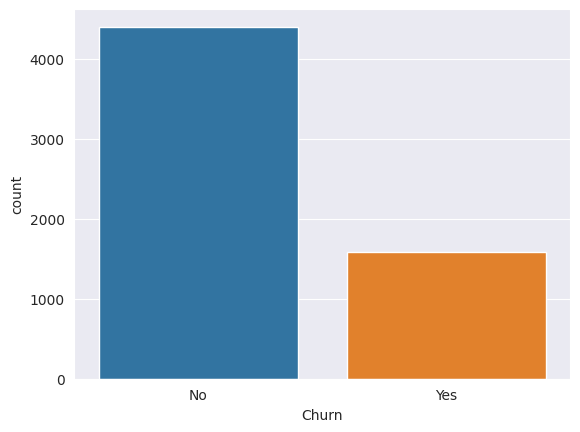

In [19]:
# how balanced is the data
sns.countplot(x='Churn', data=users);

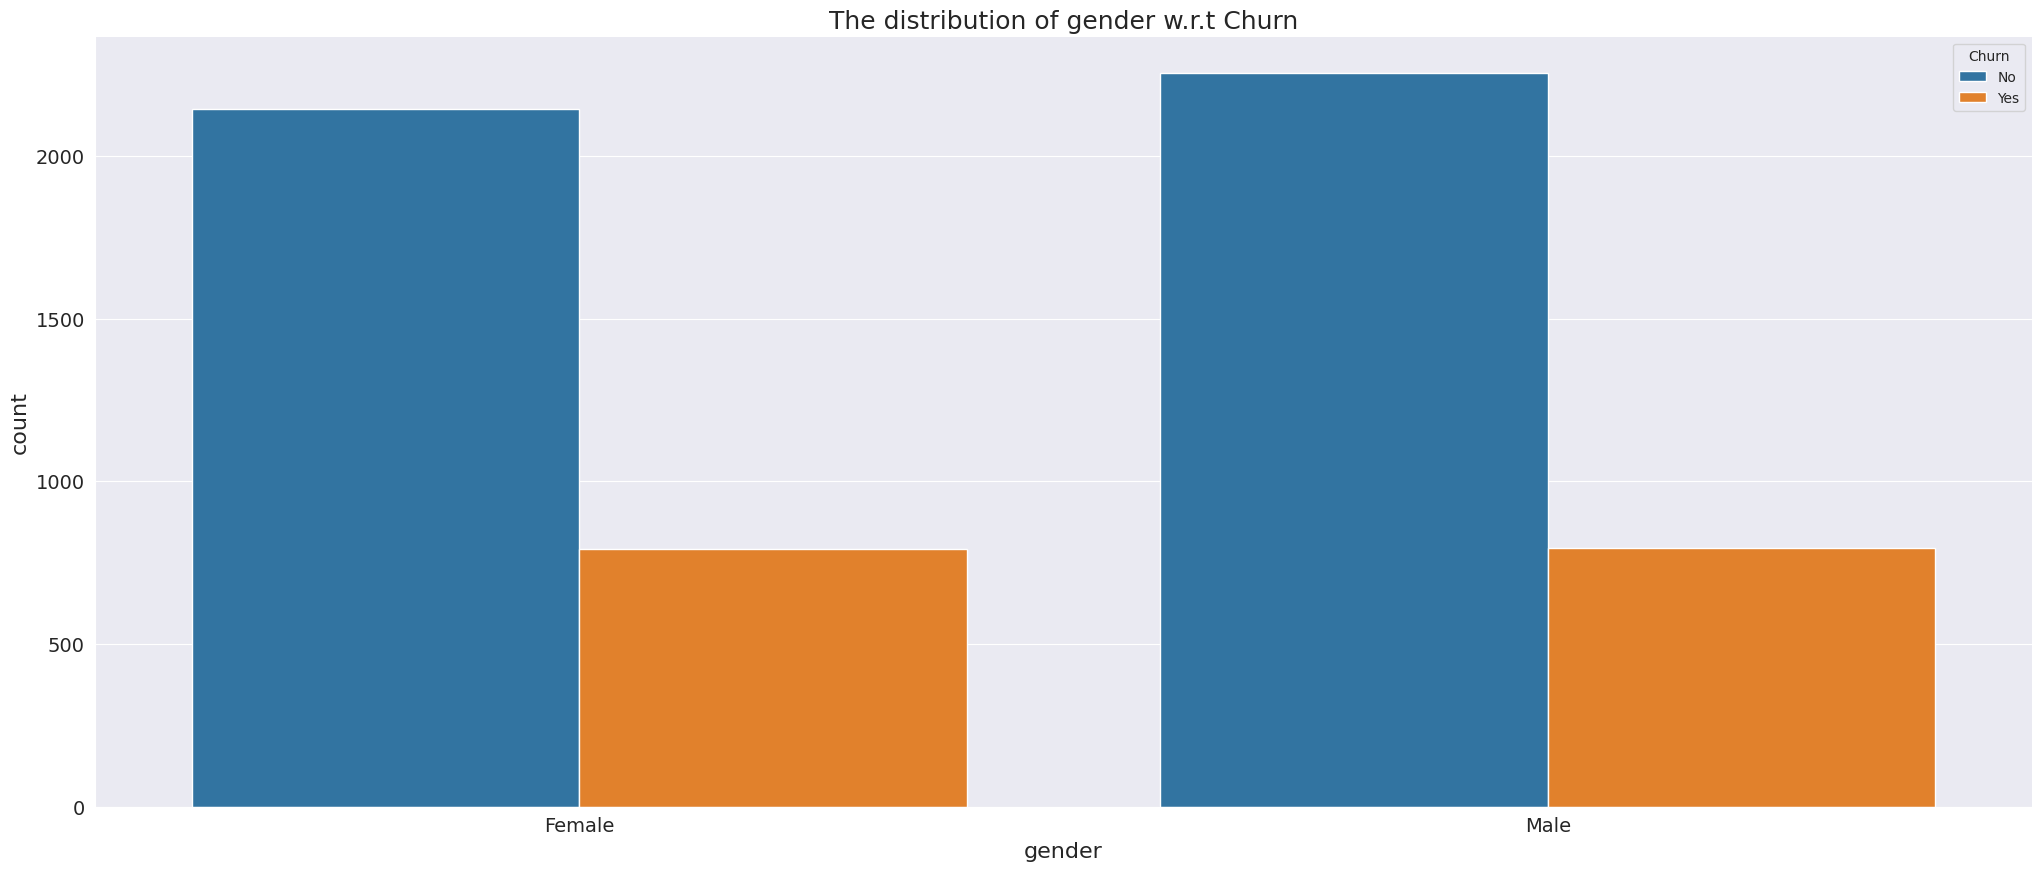

In [20]:
# the gender distribution
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.countplot(x='gender', hue='Churn', data=users)
ax.set_title('The distribution of gender w.r.t Churn', fontsize=18)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('gender', fontsize=16)
ax.tick_params(labelsize=14)
sns.despine()

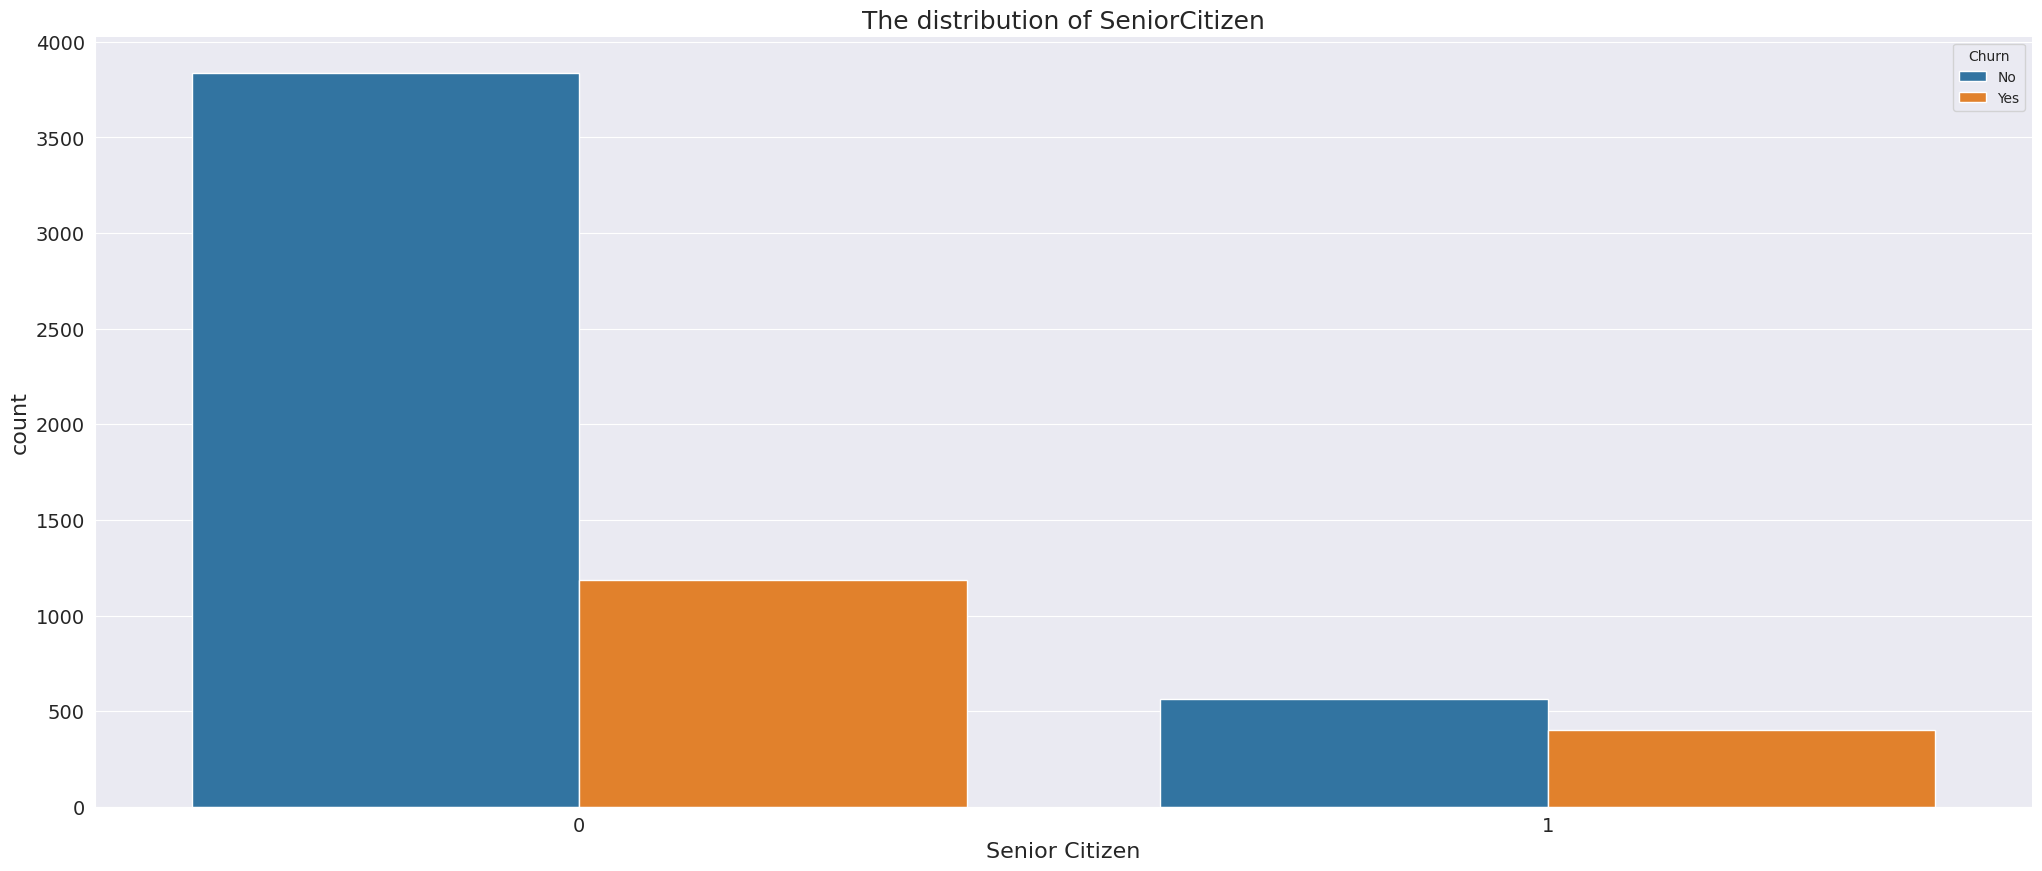

In [21]:
# senior citizens
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.countplot(x='SeniorCitizen', hue='Churn', data=users)
ax.set_title('The distribution of SeniorCitizen', fontsize=18)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('Senior Citizen', fontsize=16)
ax.tick_params(labelsize=14)
sns.despine()

#####  There is a big difference between the working and retired population . This shows that most of the telecom services users are in the working population.

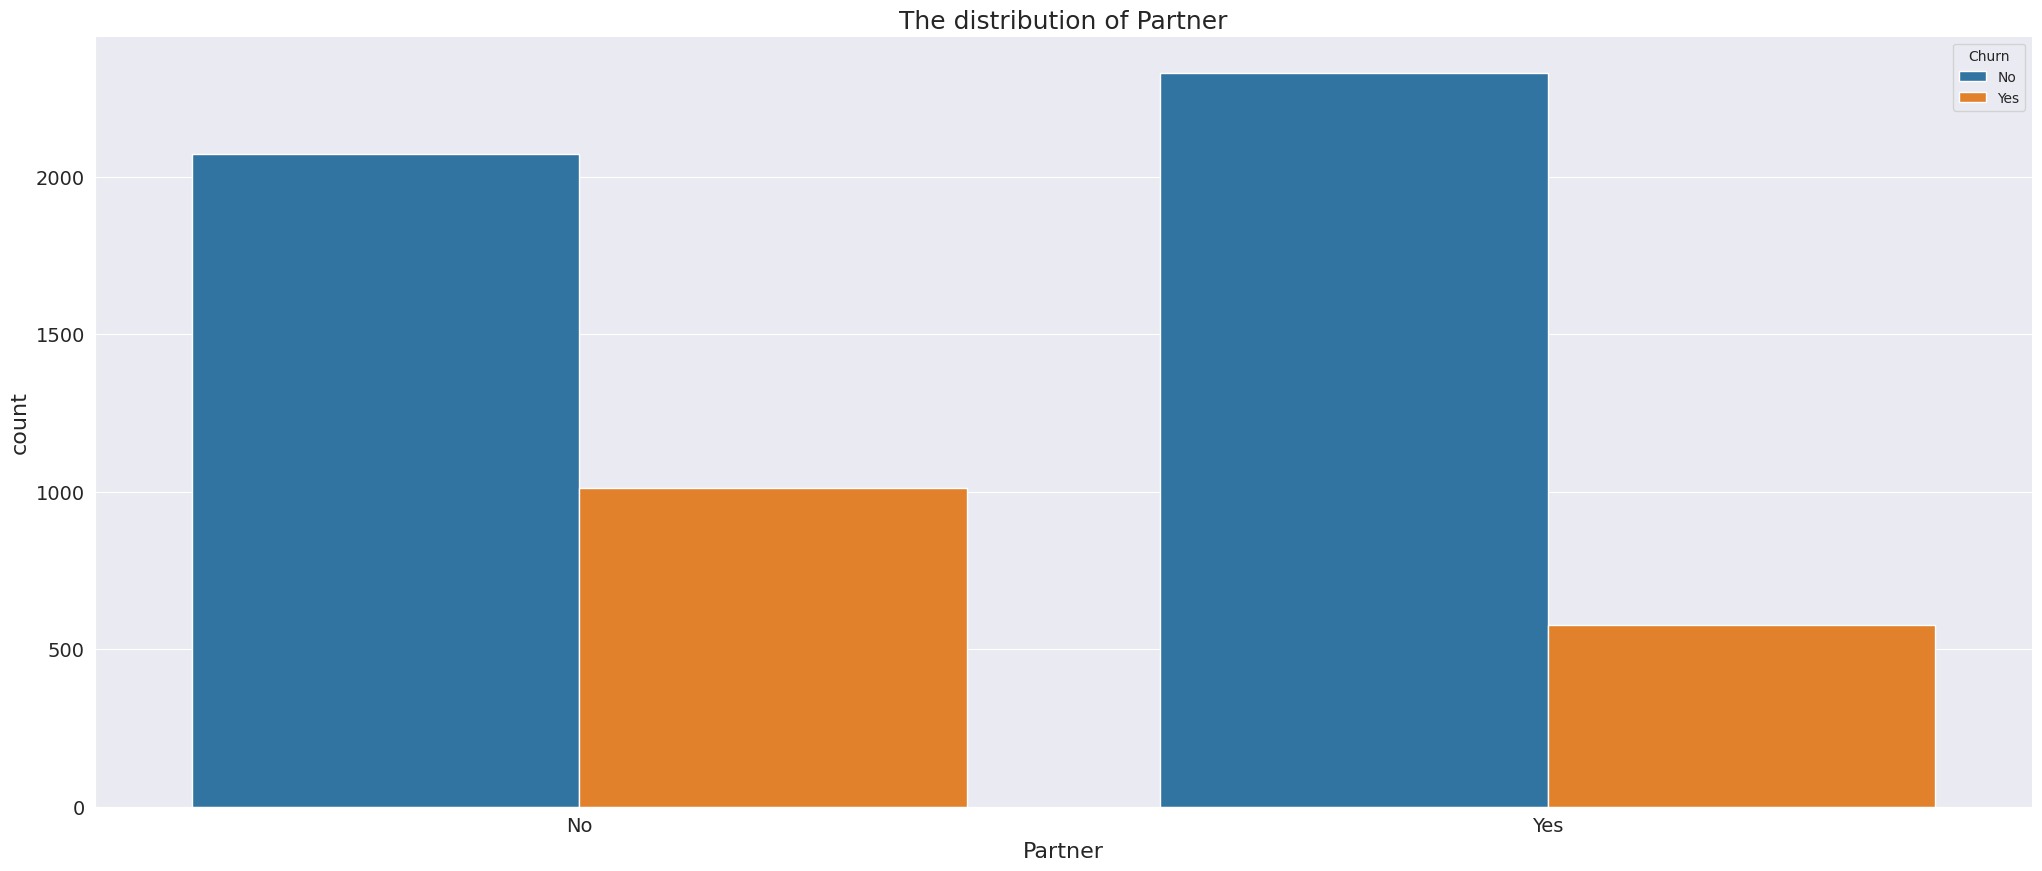

In [22]:
# Partner
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.countplot(x='Partner', hue='Churn', data=users)
ax.set_title('The distribution of Partner', fontsize=18)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('Partner', fontsize=16)
ax.tick_params(labelsize=14)
sns.despine()

#####  There is more number of users who aren't married  leaving the services

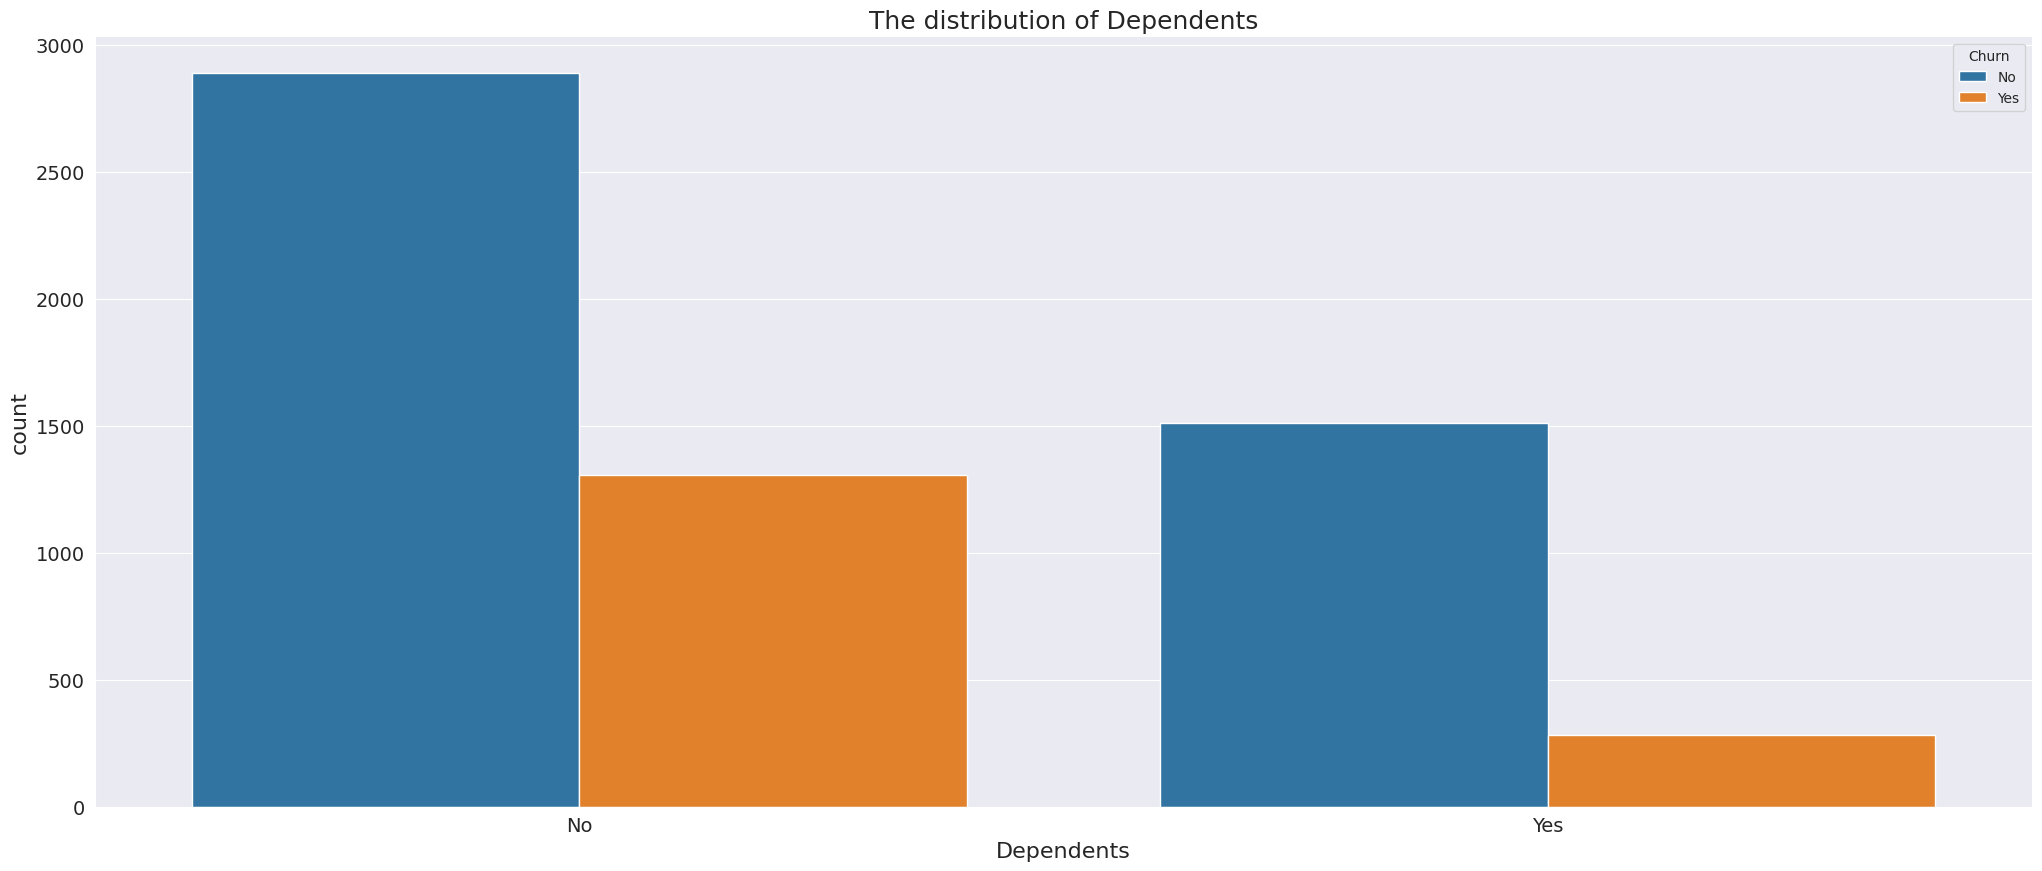

In [23]:
# Dependents
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.countplot(x='Dependents', hue='Churn', data=users)
ax.set_title('The distribution of Dependents', fontsize=18)
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('Dependents', fontsize=16)
ax.tick_params(labelsize=14)
sns.despine()

In [24]:
dep_count = users[(users.Dependents == 'Yes') & (users.Churn == 'Yes')].shape[0]
ndep = users[(users.Dependents == 'No') & (users.Churn == 'No')].shape[0]
print(f'with dependents {dep_count} \n without {ndep}')

with dependents 281 
 without 2889


##### Most users of this phoneservices don't have dependents  with more of them opting to stay with telecom service providers.

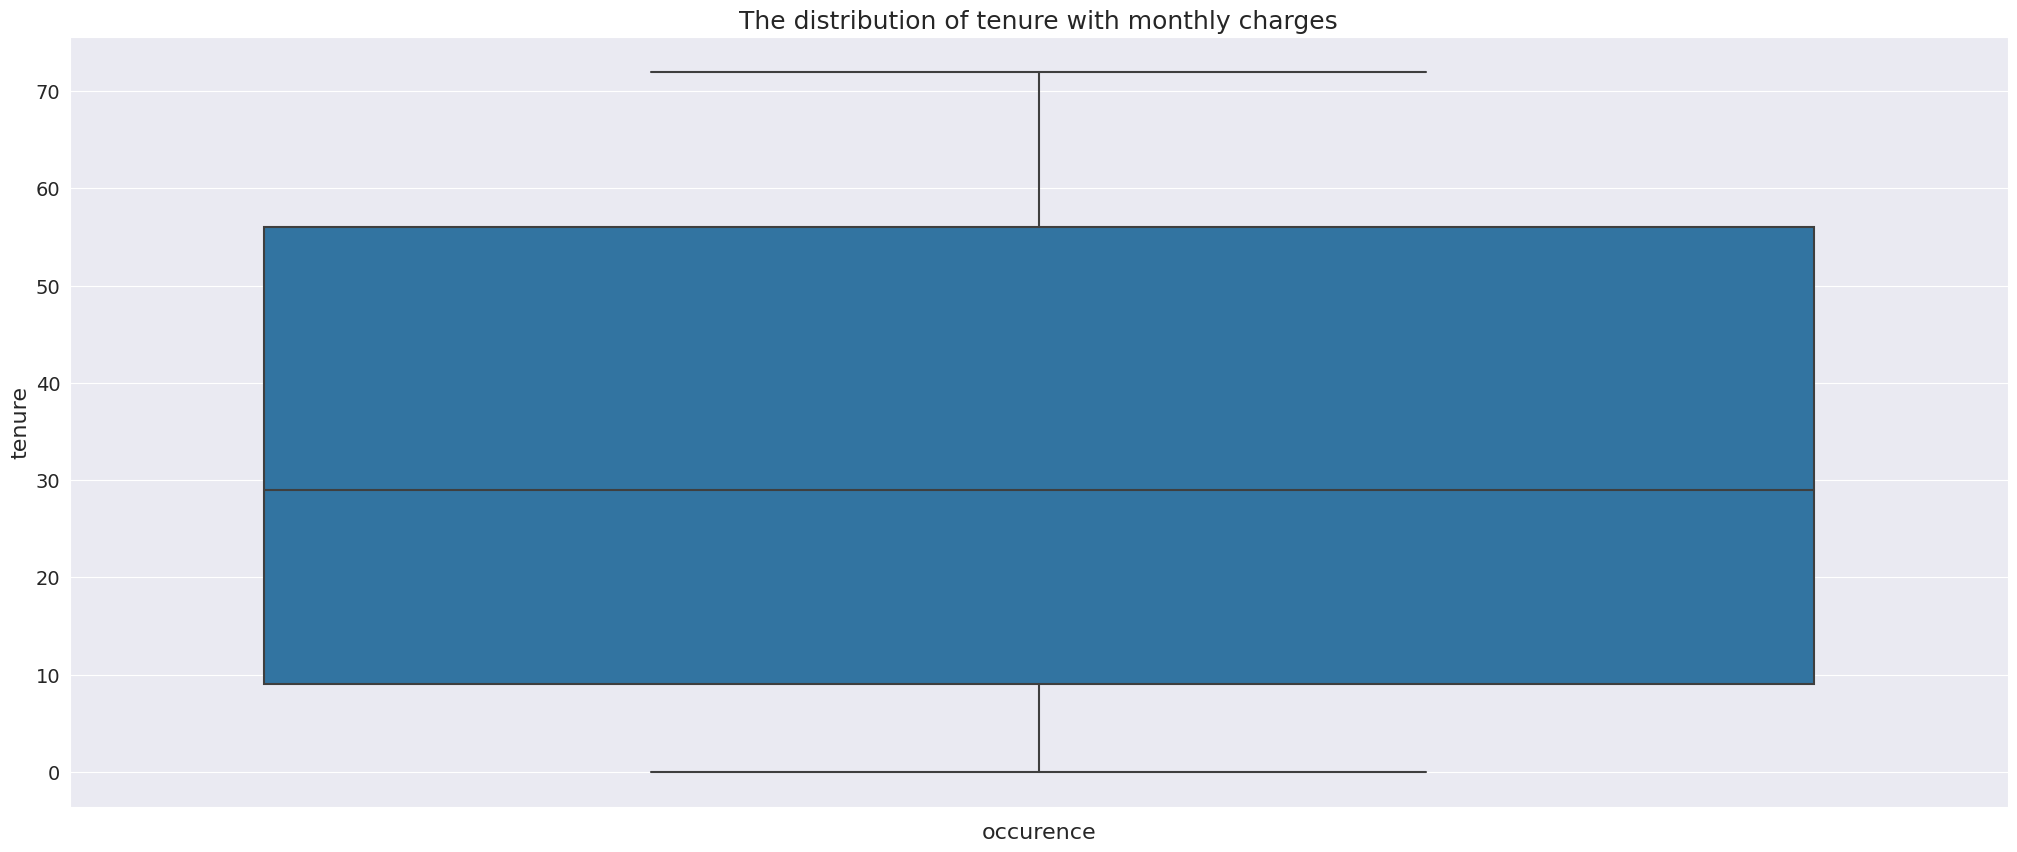

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.boxplot(y='tenure', hue='Churn', data=users)
ax.set_title('The distribution of tenure with monthly charges', fontsize=18)
ax.set_ylabel('tenure', fontsize=16)
ax.set_xlabel('occurence', fontsize=16)
ax.tick_params(labelsize=14)

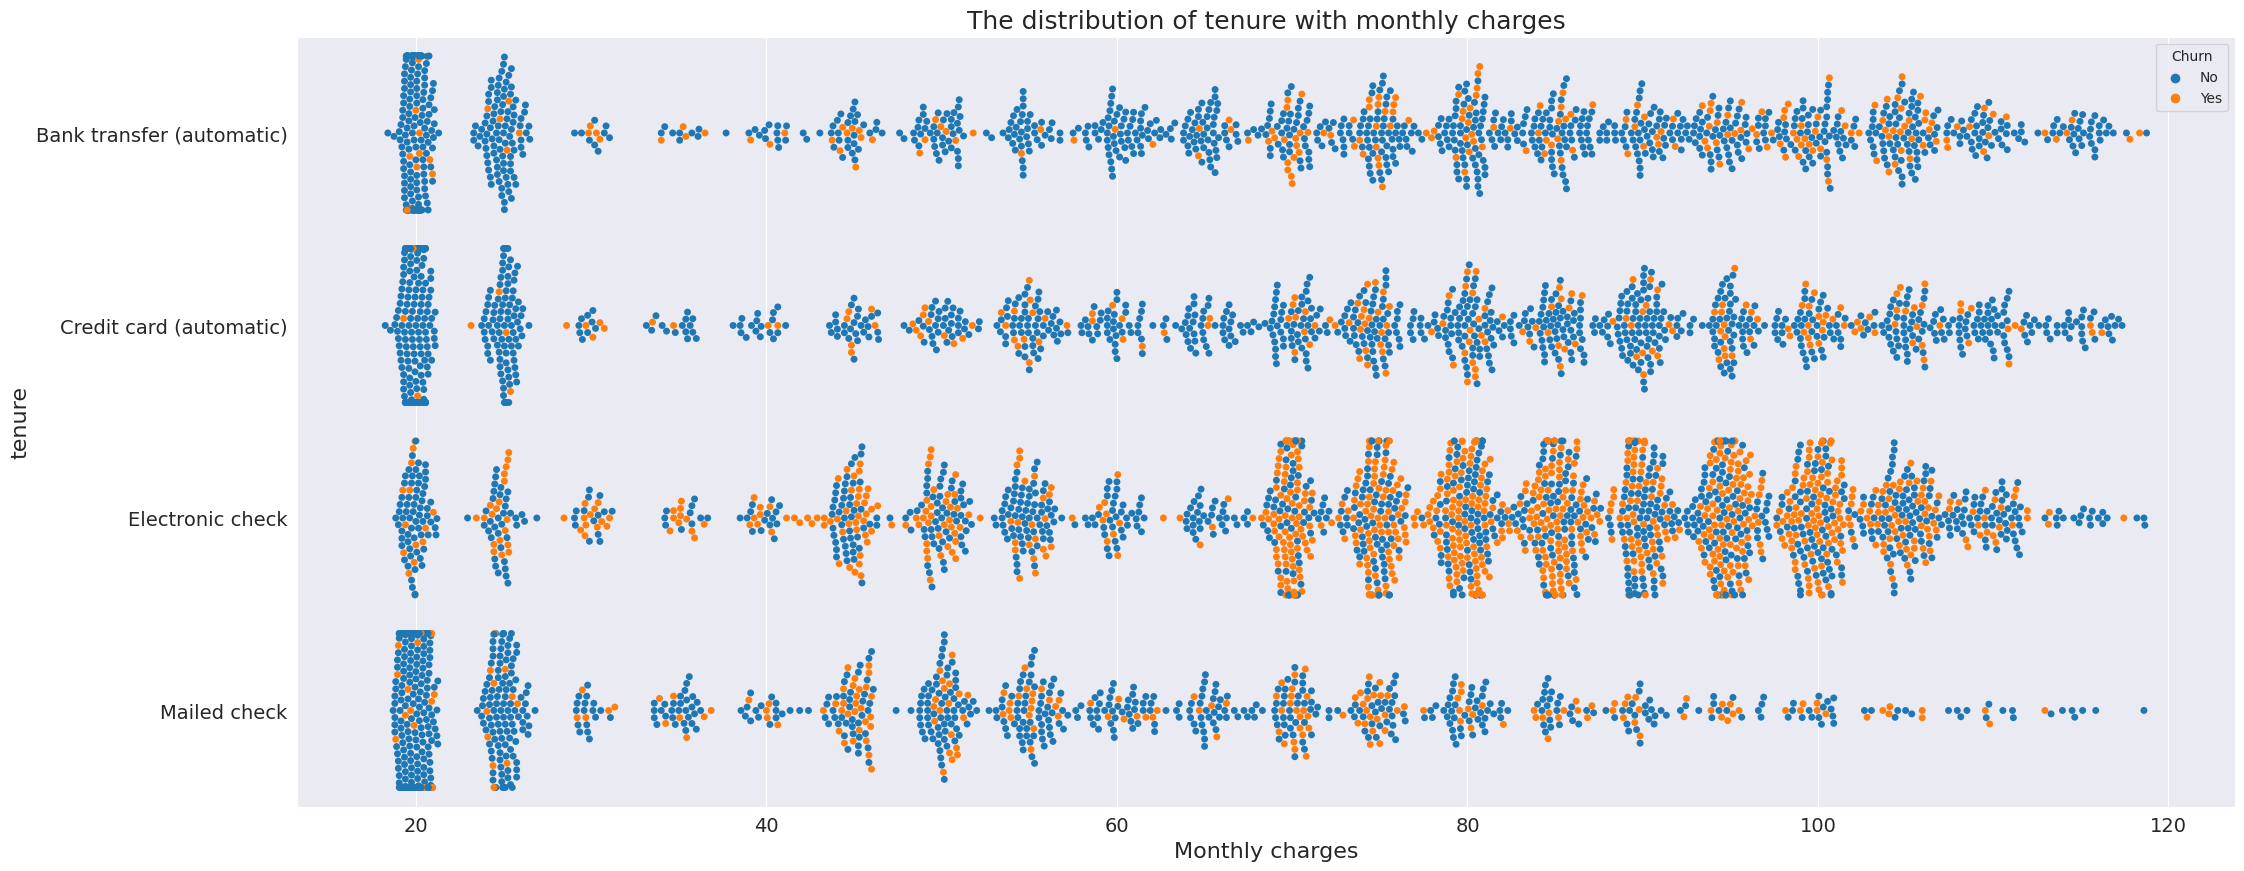

In [26]:
# tenure
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.swarmplot(x='MonthlyCharges', y = 'PaymentMethod', hue='Churn', data=users)
ax.set_title('The distribution of tenure with monthly charges', fontsize=18)
ax.set_ylabel('tenure', fontsize=16)
ax.set_xlabel('Monthly charges', fontsize=16)
ax.tick_params(labelsize=14)

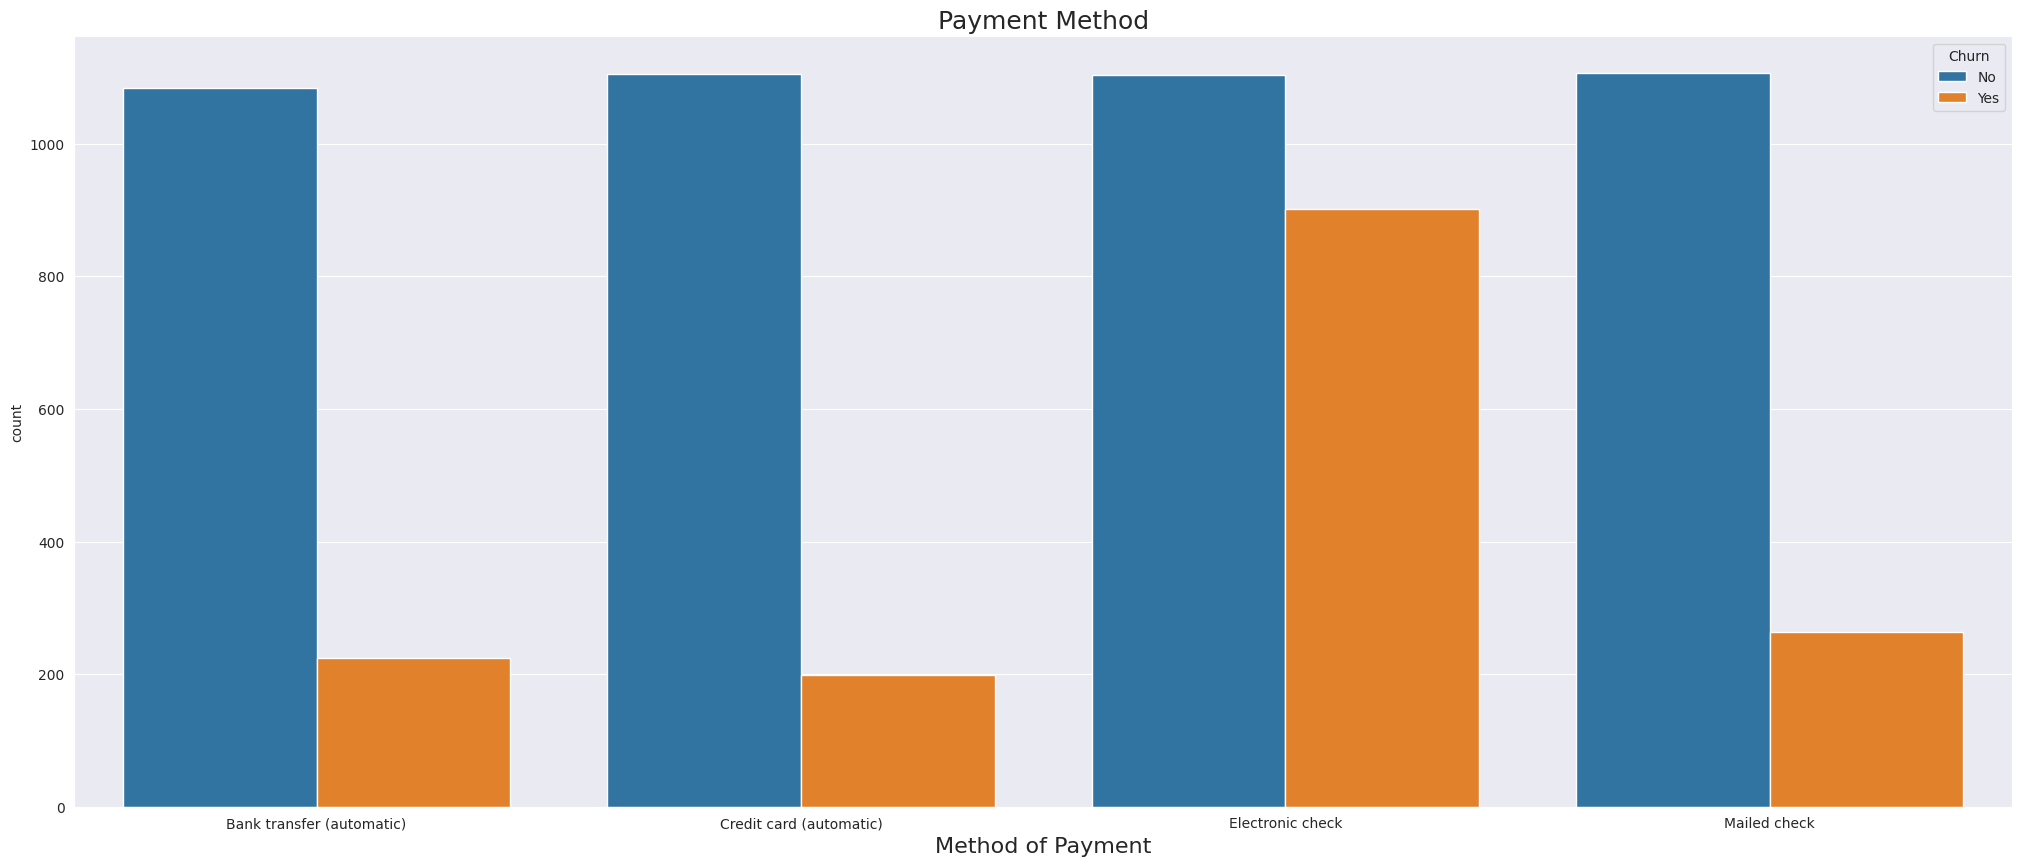

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sns.countplot(x='PaymentMethod', hue='Churn', data = users)
ax.set_title('Payment Method', fontsize=18)
ax.set_xlabel('Method of Payment', fontsize=16)
sns.despine()

##### A high number of users with other payment methods stay with telecom. Customers  who churn the services  with electronic checks  methods are more compared to customers who churn services with other payment methods.

In [ ]:
y_le = LabelEncoder()
users['Churn'] = y_le.fit_transform(users['Churn'])


### Modelling  - CatBoost can handle categorical features without the need for encoding

In [40]:
cat_features = [col for col in users.columns if users[col].dtype == 'category']
cat_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

In [37]:
X = users.drop(['Churn'], axis=1)
y = users['Churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

print(f"{X_train.shape}, {y_train.shape}, \n{X_val.shape}, {y_val.shape}")

(4788, 19), (4788,), 
(1198, 19), (1198,)


In [46]:
clf = CatBoostClassifier(iterations=100, learning_rate=1e-3, cat_features=cat_features)

clf.fit(X_train, y_train)

preds = clf.predict(X_val)

display(roc_auc_score(y_val, preds))
display(f1_score(y_val, preds))


0:	learn: 0.6927772	total: 5.02ms	remaining: 497ms
1:	learn: 0.6923699	total: 12.3ms	remaining: 604ms
2:	learn: 0.6919844	total: 18.3ms	remaining: 593ms
3:	learn: 0.6915871	total: 23.7ms	remaining: 568ms
4:	learn: 0.6912111	total: 27.9ms	remaining: 530ms
5:	learn: 0.6907925	total: 32.7ms	remaining: 513ms
6:	learn: 0.6904102	total: 37.6ms	remaining: 500ms
7:	learn: 0.6900415	total: 42.8ms	remaining: 492ms
8:	learn: 0.6896693	total: 45.8ms	remaining: 463ms
9:	learn: 0.6892887	total: 50.7ms	remaining: 456ms
10:	learn: 0.6889170	total: 55.5ms	remaining: 449ms
11:	learn: 0.6885293	total: 59.5ms	remaining: 436ms
12:	learn: 0.6881706	total: 62.8ms	remaining: 420ms
13:	learn: 0.6877998	total: 66.7ms	remaining: 410ms
14:	learn: 0.6874316	total: 71.6ms	remaining: 406ms
15:	learn: 0.6870280	total: 76.6ms	remaining: 402ms
16:	learn: 0.6866295	total: 82.3ms	remaining: 402ms
17:	learn: 0.6862645	total: 87.3ms	remaining: 398ms
18:	learn: 0.6858934	total: 92.2ms	remaining: 393ms
19:	learn: 0.6855140	t

0.6759463675968445

0.517304189435337

In [49]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       894
           1       0.58      0.47      0.52       304

    accuracy                           0.78      1198
   macro avg       0.70      0.68      0.69      1198
weighted avg       0.77      0.78      0.77      1198



Text(0.5, 1.0, 'Feature Importance')

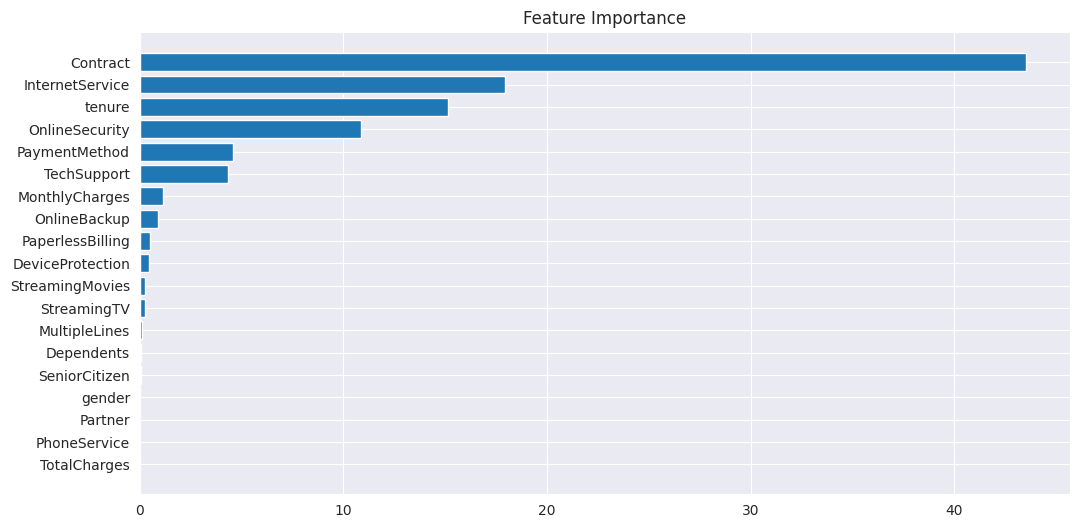

In [50]:

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

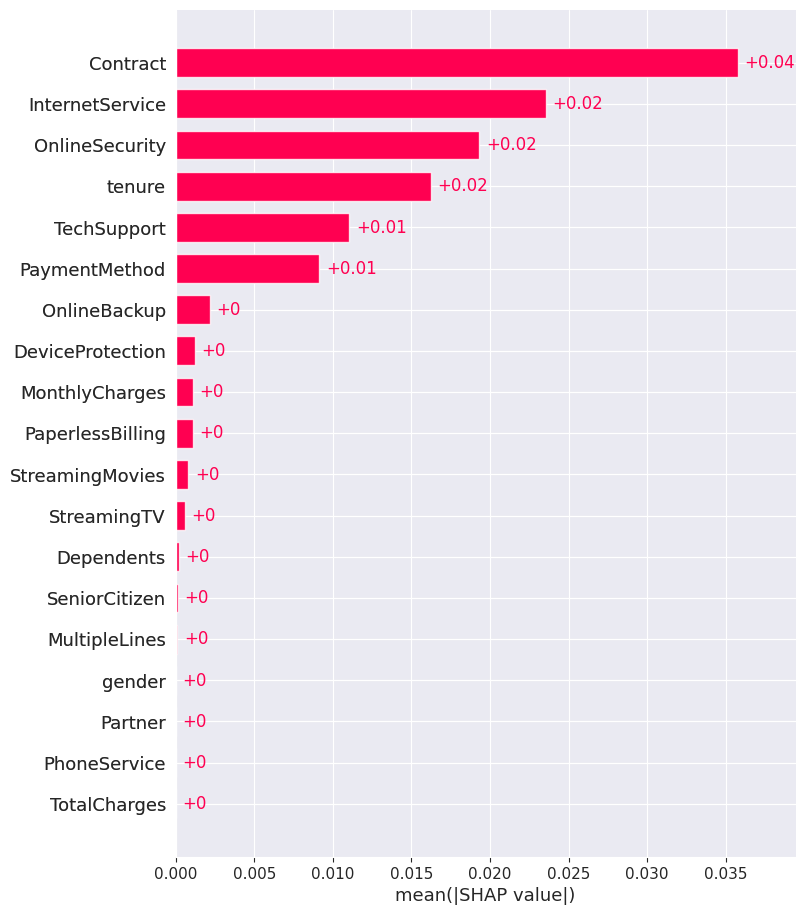

In [55]:
shap_explainer = shap.Explainer(clf)
shap_values = shap_explainer(X_val)

shap.plots.bar(shap_values, max_display=X_val.shape[0])